In [ ]:
!pip3 install gym-retro

     |████████████████████████████████| 162.0MB 28kB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
!python -m retro.import /content/gdrive/My\ Drive/Colab\ Notebooks/aps360/project/

Importing FerrariGrandPrixChallenge-Genesis
Imported 1 games


In [ ]:
import retro
import numpy as np
import matplotlib.pyplot as plt
import sys
import torch
from torch import nn
from torch import optim
import torchvision.models
import gym
import torch.nn.functional as F
from math import floor
import time

In [ ]:
seed = 10
torch.manual_seed(seed)
np.random.seed(seed)

In [ ]:
class Discretizer(gym.ActionWrapper):
    """
    Wrap a gym environment and make it use discrete actions.
    Args:
        combos: ordered list of lists of valid button combinations
    """

    def __init__(self, env, combos):
        super().__init__(env)
        assert isinstance(env.action_space, gym.spaces.MultiBinary)
        buttons = env.unwrapped.buttons
        print(buttons)
        self._decode_discrete_action = []
        for combo in combos:
            arr = np.array([False] * env.action_space.n)
            for button in combo:
                arr[buttons.index(button)] = True
            self._decode_discrete_action.append(arr)
        self.action_space = gym.spaces.Discrete(len(self._decode_discrete_action))

    def action(self, act):
        return self._decode_discrete_action[act].copy()

In [ ]:
class Policy(nn.Module):
    def __init__(self, env, lr, kernel_sizes = [2, 2, 2]):
        super(Policy, self).__init__()
        self.process_image = nn.Sequential(
            nn.Conv2d(3, 10, kernel_size=kernel_sizes[0]),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.Conv2d(10, 17, kernel_size=kernel_sizes[1]),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(17),
            nn.ReLU(),
            nn.Conv2d(17, 25, kernel_size=kernel_sizes[2]),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(25),
            nn.ReLU()
        )

        self.n_outputs = env.action_space.n
        self.input_size = 25*self.size_after_conv(224, kernel_sizes)*self.size_after_conv(320, kernel_sizes)

        self.pick_action = nn.Sequential(
            nn.Linear(self.input_size, 40),
            nn.Dropout(p=0.5),
            nn.ReLU(),           
            nn.Linear(40, self.n_outputs)
        )
        
        self.lr = lr
        self.optimizer = optim.Adam(self.parameters(), self.lr)

    def size_after_conv(self, x, kernel_sizes):
        s = floor((x - kernel_sizes[0] + 1)/2)
        s = floor((s - kernel_sizes[1] + 1)/2)
        s = floor((s - kernel_sizes[2] + 1)/2)
        return s
            
    def forward(self, x):
        out = self.process_image(x)
        out = out.view(-1, self.input_size)
        out = self.pick_action(out)
        return out


In [ ]:
class Agent(object):
    def __init__(self, env, lr = 0.01, gamma=0.99):
        self.gamma = gamma
        self.lr = lr
        # self.i=0
        self.reward_memory = []
        self.action_memory = []
        self.policy = Policy(env, lr)
        self.policy.cuda()
        #self.policy.load_state_dict(torch.load("/content/gdrive/My Drive/Colab Notebooks/aps360/project/Model/19/model_{}".format(41)))

    def choose_action(self, state, ep):
        if (ep%2!=0):
            probs = F.softmax(self.policy.forward(state), dim=1)
            action_probs = torch.distributions.Categorical(probs)
            action = action_probs.sample()
            log_probs = action_probs.log_prob(action)
            # self.i=0
        else:
            probs = (1/4)*np.ones(4)
            probs=torch.tensor(probs, device="cuda:0", requires_grad=True)
            action_probs = torch.distributions.Categorical(probs)
            action = action_probs.sample()
            log_probs = action_probs.log_prob(action) 
        #     self.i+=1         
        self.action_memory.append(log_probs)
        return action.item()

    def remember_rewards(self, reward):
        self.reward_memory.append(reward)

    def discount_rewards(self):
        discounted_rewards = np.zeros_like(self.reward_memory, dtype=np.float64)
        for t in range(len(self.reward_memory)):
            G_t = 0
            discount = 1
            for j in range(t, len(self.reward_memory)):
                G_t += self.reward_memory[j]*discount
                discount *= self.gamma

            discounted_rewards[t] = G_t
        
        mean = np.mean(discounted_rewards)
        std_dev = np.std(discounted_rewards) if np.std(discounted_rewards) > 0 else 1
        discounted_rewards = (discounted_rewards - mean)/std_dev
        return discounted_rewards

    def learn(self):
        
        
        rewards = torch.Tensor(self.discount_rewards()).cuda()
        
        loss = 0
        for r, logprob in zip(rewards, self.action_memory):
            loss -= r*logprob
        self.policy.optimizer.zero_grad() # zero out the gradient from last time
        # print("loss = ", loss)
        loss.backward()
        self.policy.optimizer.step()

        self.action_memory.clear()
        self.reward_memory.clear()       


In [ ]:
def main():
    env = retro.make(game='FerrariGrandPrixChallenge-Genesis', record='.')
    env = Discretizer(env, combos=[['A'], ['B'], ['LEFT', 'A'], ['RIGHT', 'A']])
    #env = Discretizer(env, combos=[['A'], ['LEFT', 'A'], ['RIGHT', 'A']])
    agent = Agent(env, lr = 0.001, gamma=0.55)
    

    score_history = []
    score = 0
    n_episodes = 200

    for i in range(0, n_episodes):
        print("Episode: {}, Score: {}".format(i + 1, score))
        done = False
        score = 0
        prev_observation = env.reset()
        prev_observation = prev_observation.transpose((2,0,1))
        new_observation, prev_speed, _, _ = env.step(0)
        new_observation = new_observation.transpose((2,0,1))

        state = new_observation - prev_observation
        state = torch.Tensor(state).cuda().unsqueeze_(0)
        num_steps = 0
        actions=[]

        while not done:
            torch.cuda.empty_cache()
            prev_observation = new_observation

            # if (i==0):
            #   prob = (1/4)*np.ones(4)
            #   action = np.random.choice([0,1,2,3], p=prob)
            # else:
            action = agent.choose_action(state, i)
            actions.append(action)
            new_observation, speed, done, info = env.step(action)
            num_steps += 1

            new_observation = new_observation.transpose((2,0,1))
            state = new_observation - prev_observation
            # plt.imshow(state.transpose(1,2,0))
            # plt.show()
            state = torch.Tensor(state).cuda().unsqueeze_(0)

            # if (new_observation[0,215,95] != 96 and new_observation[1,215,95] != 100) or (new_observation[0,215,205] != 96 and new_observation[1,215,205] != 100): 
            #     reward = 0
            # elif reward < prev_speed:
            #     reward = 0
            # if (speed>250):
            #       reward=3
            # if (speed>200):
            #      reward=3
            if (speed>150):
                 reward=2
            elif (speed>100):
                 reward=1
            elif(speed>50):
                  reward=1
            else:
                reward=0
            

            prev_speed = reward

            agent.remember_rewards(reward)
            score += reward

            if num_steps > 0 and num_steps % 500 == 0:
                print(info)
                print("Episode: {}, Num steps: {}, Action: {}, Reward: {}".format(i + 1, num_steps, action, reward))
                print(score)

            if num_steps > 0 and num_steps % 1000 == 0:
                agent.learn()

        # if (i%2!=0):
        #     plt.plot(range(1,i+1), score_history)
        #     plt.title("Reward as a function of the number of epochs")
        #     plt.ylabel("Reward")
        #     plt.xlabel("epoch")
        #     plt.show()            
        plt.hist(actions, bins=4)
        plt.show()
        score_history.append(score)
        agent.learn()
        torch.save(agent.policy.state_dict(), "/content/gdrive/My Drive/Colab Notebooks/aps360/project/Model/21/model_{}".format(i))


['B', 'A', 'MODE', 'START', 'UP', 'DOWN', 'LEFT', 'RIGHT', 'C', 'Y', 'X', 'Z']
Episode: 1, Score: 0
{'best_lap': 595999, 'lap': 1, 'speed': 15, 'time': 689}
Episode: 1, Num steps: 500, Action: 3, Reward: 0
0
{'best_lap': 595999, 'lap': 1, 'speed': 12, 'time': 1439}
Episode: 1, Num steps: 1000, Action: 1, Reward: 0
112
{'best_lap': 595999, 'lap': 1, 'speed': 12, 'time': 2189}
Episode: 1, Num steps: 1500, Action: 2, Reward: 0
324
{'best_lap': 595999, 'lap': 1, 'speed': 56, 'time': 2939}
Episode: 1, Num steps: 2000, Action: 1, Reward: 1
376
{'best_lap': 595999, 'lap': 1, 'speed': 91, 'time': 3689}
Episode: 1, Num steps: 2500, Action: 0, Reward: 1
876
{'best_lap': 595999, 'lap': 1, 'speed': 28, 'time': 4439}
Episode: 1, Num steps: 3000, Action: 3, Reward: 0
876
{'best_lap': 595999, 'lap': 1, 'speed': 12, 'time': 5189}
Episode: 1, Num steps: 3500, Action: 2, Reward: 0
876
{'best_lap': 595999, 'lap': 1, 'speed': 10, 'time': 5939}
Episode: 1, Num steps: 4000, Action: 3, Reward: 0
876
{'best_l

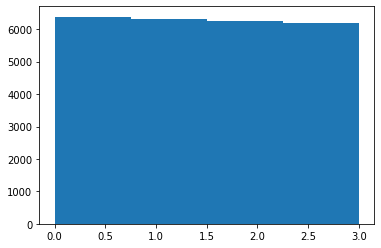

Episode: 2, Score: 7131
{'best_lap': 595999, 'lap': 1, 'speed': 23, 'time': 689}
Episode: 2, Num steps: 500, Action: 0, Reward: 0
164
{'best_lap': 595999, 'lap': 1, 'speed': 52, 'time': 1439}
Episode: 2, Num steps: 1000, Action: 0, Reward: 1
172
{'best_lap': 595999, 'lap': 1, 'speed': 9, 'time': 2189}
Episode: 2, Num steps: 1500, Action: 0, Reward: 0
264
{'best_lap': 595999, 'lap': 1, 'speed': 11, 'time': 2939}
Episode: 2, Num steps: 2000, Action: 2, Reward: 0
264
{'best_lap': 595999, 'lap': 1, 'speed': 12, 'time': 3689}
Episode: 2, Num steps: 2500, Action: 1, Reward: 0
264
{'best_lap': 595999, 'lap': 1, 'speed': 11, 'time': 4439}
Episode: 2, Num steps: 3000, Action: 0, Reward: 0
264
{'best_lap': 595999, 'lap': 1, 'speed': 18, 'time': 5189}
Episode: 2, Num steps: 3500, Action: 1, Reward: 0
264


In [ ]:
main()